# Modules needed to be verified


## Basic Building Blocks (bb)
all the components in the layers file

- FlaxBertForSequenceClassification
    - FlaxBertForSequenceClassificationModule
        - FlaxBertModule
            - FlaxBertEmbeddings
                - Add
                - LayerNorm
                - Dropout
            - FlaxBertEncoder
                - FlaxBertLayerCollection
                    - FlaxBertLayer
                        - FlaxBertAttention
                            - FlaxBertSelfAttention(bb only)
                            - ~~FlaxBertSelfOutput(bb only)~~ ?
                        - ~~FlaxBertIntermediate(bb only)~~
                        - FlaxBertOutput(bb only)
                    - FlaxBertCheckpointLayer(cond.)
            - FlaxBertPooler(bb only)
        - Dropout
        - Dense

## Basic Building Block verification.
- FlaxBertSelfAttention vs.     BertSelfAttention
- FlaxBertSelfOutput    vs.     BertSelfOutput
- FlaxBertIntermediate  vs.     BertIntermediate
- FlaxBertOutput        vs.     BertOutput
- FlaxBertPooler        vs.     BertPooler

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import torch
import torch.nn as nn
import jax
import jax.numpy as jnp
import numpy as np
from clu import parameter_overview
import flax.linen as fnn

sys.path.insert(0, '../bert')
sys.path.insert(0, '../bert_torch')
from BERT import *
from modeling_flax_bert import *
import modeling_flax_bert as layers
from transformers import BertConfig, BertTokenizer
import layers as tl
import bert_explainability_layers as fl


/local/.conda/envs/dl_sys/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-04 15:44:33.955805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 15:44:33.979116: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-04 15:44:34.430193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-04 15:44:34.430259: W tensorflow/stream_executor/platform/default/dso_load

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
configuration = BertConfig()
print(configuration.add_cross_attention)

False


In [5]:
text_batch = ["Hello world!"]
fl_inputs = tokenizer(text_batch)
# print(fl_inputs.__class__)
# print(dict(inputs).__class__)

for k in fl_inputs:
    fl_inputs[k] = jnp.array(fl_inputs[k])
fl_inputs['position_ids'] = jnp.arange(fl_inputs['input_ids'].shape[0])

input_ids = jnp.array(fl_inputs["input_ids"])
token_ids = jnp.array(fl_inputs["token_type_ids"])
attention_mask = jnp.array(fl_inputs["attention_mask"])
position_ids = jnp.arange(input_ids.shape[0])

pt_inputs = tokenizer(text_batch, return_tensors='pt')
pt_inputs['position_ids'] = torch.tensor(np.arange(pt_inputs['input_ids'].shape[0]))
pt_input_ids = pt_inputs["input_ids"]
pt_token_ids = pt_inputs["token_type_ids"]
pt_attention_mask = pt_inputs["attention_mask"]
pt_position_ids = torch.tensor(np.arange(pt_input_ids.shape[0]))

print(fl_inputs, pt_inputs)

{'input_ids': DeviceArray([[ 101, 7592, 2088,  999,  102]], dtype=int32), 'token_type_ids': DeviceArray([[0, 0, 0, 0, 0]], dtype=int32), 'attention_mask': DeviceArray([[1, 1, 1, 1, 1]], dtype=int32), 'position_ids': DeviceArray([0], dtype=int32)} {'input_ids': tensor([[ 101, 7592, 2088,  999,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]]), 'position_ids': tensor([0])}


In [6]:
# pt_layer = BertEmbeddings(configuration).eval()
# fl_layer = FlaxBertEmbeddings(configuration)

In [7]:
def nested_set(dic, keys, value, create_missing=True):
    d = dic
    for key in keys[:-1]:
        if key in d:
            d = d[key]
        elif create_missing:
            d = d.setdefault(key, {})
        else:
            return dic
    if keys[-1] in d or create_missing:
        d[keys[-1]] = value
    return dic


def pt2fl(pt: nn.Module, debug=False):
    vf = {}
    for k, v in pt.named_parameters():
        keys = k.split('.')
        if len(keys) >= 2:
            if debug:
                print(k, v.size())
            if keys[-2].endswith('embeddings'):
                keys[-1] = 'embedding'

            if keys[-1] == 'weight':
                if keys[-2] == 'LayerNorm':
                    keys[-1] = 'scale'
                else:
                    keys[-1] = 'kernel'

            if keys[-2] in ['dense', 'key', 'value', 'query'] and keys[-1] == 'kernel':
                nested_set(vf, keys, value=jnp.transpose(v.detach().numpy(), (1, 0)))
            else:
                nested_set(vf, keys, value=v.detach().numpy())
        else:
            if keys[-1] == 'weight':
                keys[-1] = 'kernel'
                nested_set(vf, keys, value=jnp.transpose(v.detach().numpy(), (1, 0)))
            else:
                nested_set(vf, keys, value=v.detach().numpy())
    params = {'params': vf}
    if debug:
        print('Num Prams: ', count_parameters(pt))
        print(parameter_overview.get_parameter_overview(params))
    return params


def verify_module(pt:nn.Module, fl:fnn.Module, pt_kwargs=None, fl_kwargs=None, debug=False):
    params = pt2fl(pt, debug=debug)

    pt_out = pt(**pt_kwargs)
    fl_out = fl.apply(params, **fl_kwargs)
    # print(pt_out)
    if isinstance(pt_out, tuple):
        pt_out = pt_out[0]
    if isinstance(fl_out, tuple):
        fl_out = fl_out[0]
    if isinstance(pt_out, BaseModelOutput):
        pt_out = pt_out[0]

    if isinstance(fl_out, FlaxBaseModelOutputWithPastAndCrossAttentions):
        fl_out = fl_out[0]
    if isinstance(pt_out, BaseModelOutputWithPooling):
        pt_out = pt_out[1]
    if isinstance(fl_out, FlaxBaseModelOutputWithPoolingAndCrossAttentions):
        fl_out = fl_out[1]
    print("Forward diff: ",np.abs(pt_out.detach().numpy() - fl_out).sum())

    # print(parameter_overview.get_parameter_overview(params))
    # print(pt, count_parameters(pt))

    cam = np.random.rand(*fl_out.shape)
    fl_cam = jnp.array(cam / cam.sum())
    pt_cam = torch.tensor(cam / cam.sum())

    fl_cams = fl.apply(params, fl_cam, **fl_kwargs, method=fl.relprop)
    kwargs = {'alpha': 1}
    pt_cams = pt.relprop(pt_cam, **kwargs)

    print('Flax relprop:', fl_cams)
    print('Pt relprop:', pt_cams)
    pt_sum = None
    fl_sum = None
    if isinstance(fl_cams, list) or isinstance(fl_cams, tuple):

        for i, c in enumerate(fl_cams):
            print("Relprop size:", pt_cams[i].size())
            print("Relprop", i, " diff:", np.abs(np.array(c) - pt_cams[i].detach().numpy()).sum())
            if pt_sum:
                pt_sum+=pt_cams[i].sum()
            else:
                pt_sum = pt_cams[i].sum()

            if fl_sum:
                fl_sum+=c.sum()
            else:
                fl_sum = c.sum()
    else:
        pt_sum = pt_cams.sum()
        fl_sum = fl_cams.sum()
        print("Relprop size:", pt_cams.size())
        print("Relprop diff:", np.abs(np.array(fl_cams) - pt_cams.detach().numpy()).sum())
    print("Cam sum:", pt_sum, fl_sum)
    return pt_cams, fl_cams

def verify_module_args(pt:nn.Module, fl:fnn.Module, pt_kwargs=None, fl_kwargs=None, debug=False):
    params = pt2fl(pt, debug=debug)

    pt_out = pt(*pt_kwargs)
    fl_out = fl.apply(params, *fl_kwargs)
    # print(pt_out)
    if isinstance(pt_out, tuple):
        pt_out = pt_out[0]
    if isinstance(fl_out, tuple):
        fl_out = fl_out[0]
    if isinstance(pt_out, BaseModelOutput):
        pt_out = pt_out[0]

    if isinstance(fl_out, FlaxBaseModelOutputWithPastAndCrossAttentions):
        fl_out = fl_out[0]
    if isinstance(pt_out, BaseModelOutputWithPooling):
        pt_out = pt_out[1]
    if isinstance(fl_out, FlaxBaseModelOutputWithPoolingAndCrossAttentions):
        fl_out = fl_out[1]
    print("Forward diff: ",np.abs(pt_out.detach().numpy() - fl_out).sum())
    if debug:
        # print(fl_out)
        # print(pt_out.detach().numpy())
        print(pt_out.detach().numpy() - fl_out)
    # print(parameter_overview.get_parameter_overview(params))
    # print(pt, count_parameters(pt))

    cam = np.random.rand(*fl_out.shape)
    fl_cam = jnp.array(cam / cam.sum())
    pt_cam = torch.tensor(cam / cam.sum())

    fl_cams = fl.apply(params, fl_cam, *fl_kwargs, method=fl.relprop)
    kwargs = {'alpha': 1}
    pt_cams = pt.relprop(pt_cam, **kwargs)

    print('Flax relprop:', len(fl_cams))
    print('Pt relprop:', len(pt_cams))

    if isinstance(fl_cams, list) or isinstance(fl_cams, tuple):
        for i, c in enumerate(fl_cams):
            print("Relprop size:", pt_cams[i].size())
            print("Relprop", i, " diff:", np.abs(np.array(c) - pt_cams[i].detach().numpy()).sum())
    else:
        print("Relprop size:", pt_cams.size(), ". Cam sum:", fl_cams.sum(), pt_cams.sum() )
        print("Relprop diff:", np.abs(np.array(fl_cams) - pt_cams.detach().numpy()).sum())
    return pt_out, fl_out

In [8]:
"""Verified"""
pt_m = BertEmbeddings(configuration).eval()
fl_m = FlaxBertEmbeddings(configuration)
fl_in = fl_inputs.copy()
pt_in = pt_inputs.copy()
print(fl_in, pt_in)
# fl_in.pop('attention_mask', None)
pt_in.pop('attention_mask', None)
pt_out, fl_out = verify_module(pt_m, fl_m, pt_in, fl_in, debug=True)

print(pt_out.shape)

{'input_ids': DeviceArray([[ 101, 7592, 2088,  999,  102]], dtype=int32), 'token_type_ids': DeviceArray([[0, 0, 0, 0, 0]], dtype=int32), 'attention_mask': DeviceArray([[1, 1, 1, 1, 1]], dtype=int32), 'position_ids': DeviceArray([0], dtype=int32)} {'input_ids': tensor([[ 101, 7592, 2088,  999,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]]), 'position_ids': tensor([0])}
word_embeddings.weight torch.Size([30522, 768])
position_embeddings.weight torch.Size([512, 768])
token_type_embeddings.weight torch.Size([2, 768])
LayerNorm.weight torch.Size([768])
LayerNorm.bias torch.Size([768])
Num Prams:  23837184
+----------------------------------------+--------------+------------+-----------+-------+
| Name                                   | Shape        | Size       | Mean      | Std   |
+----------------------------------------+--------------+------------+-----------+-------+
| params/LayerNorm/bias                  | (768,)       | 768       

In [9]:
all_head_size = configuration.num_attention_heads * int(configuration.hidden_size / configuration.num_attention_heads)
q = tl.Linear(configuration.hidden_size, all_head_size).eval()
k = fl.Dense(configuration.hidden_size, all_head_size)
inputs = np.random.rand(*fl_out.shape)
fl_in = jnp.array(inputs)
pt_in =  torch.Tensor(inputs)
lpt_out, lfl_out = verify_module_args(q, k, pt_in, fl_in, debug=True)
print(lpt_out.dtype)
print(lfl_out.dtype)

Num Prams:  590592
+---------------+------------+---------+-----------+--------+
| Name          | Shape      | Size    | Mean      | Std    |
+---------------+------------+---------+-----------+--------+
| params/bias   | (768,)     | 768     | -0.000511 | 0.0202 |
| params/kernel | (768, 768) | 589,824 | 2.52e-05  | 0.0208 |
+---------------+------------+---------+-----------+--------+
Total: 590,592
Forward diff:  0.00029218418
[[-2.9802322e-08  1.7881393e-07  1.4901161e-08 ...  1.7881393e-07
   2.9802322e-08  5.9604645e-08]
 [ 1.4901161e-08 -7.4505806e-09  1.1920929e-07 ... -2.9802322e-08
   7.4505806e-08  5.9604645e-08]
 [-8.1956387e-08 -8.9406967e-08  1.1175871e-08 ...  2.3841858e-07
  -8.1956387e-08  5.9604645e-08]
 [-2.2351742e-08  2.9802322e-08  4.4703484e-08 ... -5.9604645e-08
  -2.9802322e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.7252903e-09 ...  1.1920929e-07
   1.7881393e-07  0.0000000e+00]]
Flax relprop: 5
Pt relprop: 5
Relprop size: torch.Size([5, 768]) . Ca

In [10]:
# <- BertEmbeddings
pt_m = BertAttention(configuration).eval()
fl_m = FlaxBertAttention(configuration)
inputs = np.random.rand(*fl_out.shape)
fl_in = {'hidden_states': jnp.array(inputs)}

pt_in = {'hidden_states': torch.Tensor(inputs)}

# print(np.sum(np.array(fl_in['hidden_states']) - pt_in['hidden_states'].numpy()))
fl_in['layer_head_mask'] = None
pt_in['head_mask'] = None

fl_in['attention_mask'] = fl_inputs['attention_mask']
pt_in['attention_mask'] = torch.Tensor(pt_inputs['attention_mask'].numpy())
pt_out, fl_out = verify_module(pt_m, fl_m, pt_in, fl_in, debug=True)
att_in = fl_in

self.query.weight torch.Size([768, 768])
self.query.bias torch.Size([768])
self.key.weight torch.Size([768, 768])
self.key.bias torch.Size([768])
self.value.weight torch.Size([768, 768])
self.value.bias torch.Size([768])
output.dense.weight torch.Size([768, 768])
output.dense.bias torch.Size([768])
output.LayerNorm.weight torch.Size([768])
output.LayerNorm.bias torch.Size([768])
Num Prams:  2363904
+-------------------------------+------------+---------+-----------+--------+
| Name                          | Shape      | Size    | Mean      | Std    |
+-------------------------------+------------+---------+-----------+--------+
| params/output/LayerNorm/bias  | (768,)     | 768     | 0.0       | 0.0    |
| params/output/LayerNorm/scale | (768,)     | 768     | 1.0       | 0.0    |
| params/output/dense/bias      | (768,)     | 768     | -0.000703 | 0.0206 |
| params/output/dense/kernel    | (768, 768) | 589,824 | 7.35e-05  | 0.0208 |
| params/self/key/bias          | (768,)     | 768  

In [11]:
"""Verified"""
# <- BertAttention
pt_m = BertIntermediate(configuration).eval()
fl_m = FlaxBertIntermediate(configuration)
# inputs = np.random.rand(*fl_out.shape)
att_out = np.random.rand(*fl_out.shape)

fl_in = {'hidden_states': jnp.array(att_out)}
pt_in = {'hidden_states': torch.Tensor(att_out)}
pt_out, fl_out = verify_module(pt_m, fl_m, pt_in, fl_in, debug=True)
print(pt_out.size())

dense.weight torch.Size([3072, 768])
dense.bias torch.Size([3072])
Num Prams:  2362368
+---------------------+-------------+-----------+----------+--------+
| Name                | Shape       | Size      | Mean     | Std    |
+---------------------+-------------+-----------+----------+--------+
| params/dense/bias   | (3072,)     | 3,072     | 0.000241 | 0.0206 |
| params/dense/kernel | (768, 3072) | 2,359,296 | 1.83e-05 | 0.0208 |
+---------------------+-------------+-----------+----------+--------+
Total: 2,362,368
Forward diff:  0.13115513
Flax relprop: [[[3.8992954e-04 5.3653643e-05 4.7216576e-04 ... 4.1869929e-04
   7.1022027e-05 3.6419058e-04]
  [2.4147255e-04 2.8888331e-04 1.6696571e-04 ... 3.4822416e-04
   2.8289788e-04 2.4933330e-04]
  [5.3986994e-04 3.0098023e-04 2.2024555e-04 ... 4.5775305e-05
   2.6327156e-04 5.9411264e-05]
  [2.0027079e-04 3.4479052e-04 4.6521294e-04 ... 3.4470871e-04
   2.4357894e-04 3.8454970e-04]
  [1.7698202e-04 3.1175360e-04 1.9104019e-04 ... 1.49312

In [12]:
"""Verified??"""
#TODO: make sure it's verified
pt_m = BertOutput(configuration).eval()
fl_m = FlaxBertOutput(configuration)
# inputs = np.random.rand(*fl_out.shape)
# att_out = np.random.rand(*att_out.shape)
inputs = np.random.rand(1,5,3072)
att_out = np.random.rand(1,5,768)
print(inputs.shape)
print(att_out.shape)

fl_in = {'hidden_states': jnp.array(inputs)}
pt_in = {'hidden_states': torch.Tensor(inputs)}

# print(np.sum(np.array(fl_in['hidden_states']) - pt_in['hidden_states'].numpy()))
# fl_in['layer_head_mask'] = None
# pt_in['head_mask'] = None

fl_in['attention_output'] = jnp.array(att_out)
pt_in['input_tensor'] = torch.Tensor(att_out)
pt_out, fl_out = verify_module(pt_m, fl_m, pt_in, fl_in, debug=True)
print(pt_out.size())

(1, 5, 3072)
(1, 5, 768)
dense.weight torch.Size([768, 3072])
dense.bias torch.Size([768])
LayerNorm.weight torch.Size([768])
LayerNorm.bias torch.Size([768])
Num Prams:  2361600
+------------------------+-------------+-----------+-----------+--------+
| Name                   | Shape       | Size      | Mean      | Std    |
+------------------------+-------------+-----------+-----------+--------+
| params/LayerNorm/bias  | (768,)      | 768       | 0.0       | 0.0    |
| params/LayerNorm/scale | (768,)      | 768       | 1.0       | 0.0    |
| params/dense/bias      | (768,)      | 768       | -4.52e-05 | 0.0106 |
| params/dense/kernel    | (3072, 768) | 2,359,296 | 2.92e-06  | 0.0104 |
+------------------------+-------------+-----------+-----------+--------+
Total: 2,361,600
Forward diff:  0.0008989207
Flax relprop: (DeviceArray([[[ 4.27302148e-05,  5.57678231e-06,  2.51676993e-05, ...,
                5.88701914e-06,  2.01909188e-06, -1.92677305e-07],
              [-8.17764976e-06,

In [13]:
#TODO: not verified
pt_m = BertSelfAttention(configuration).eval()
fl_m = FlaxBertSelfAttention(configuration)
inputs = np.random.rand(*fl_out.shape)
fl_in = {'hidden_states': jnp.array(inputs)}
pt_in = {'hidden_states': torch.Tensor(inputs)}

# print(np.sum(np.array(fl_in['hidden_states']) - pt_in['hidden_states'].numpy()))
fl_in['layer_head_mask'] = None
pt_in['head_mask'] = None

fl_in['attention_mask'] = fl_inputs['attention_mask']
pt_in['attention_mask'] = torch.Tensor(pt_inputs['attention_mask'].numpy())
pt_out, fl_out = verify_module(pt_m, fl_m, pt_in, fl_in, debug=True)
print(pt_out.size())

query.weight torch.Size([768, 768])
query.bias torch.Size([768])
key.weight torch.Size([768, 768])
key.bias torch.Size([768])
value.weight torch.Size([768, 768])
value.bias torch.Size([768])
Num Prams:  1771776
+---------------------+------------+---------+-----------+--------+
| Name                | Shape      | Size    | Mean      | Std    |
+---------------------+------------+---------+-----------+--------+
| params/key/bias     | (768,)     | 768     | 0.000462  | 0.021  |
| params/key/kernel   | (768, 768) | 589,824 | 1.45e-05  | 0.0208 |
| params/query/bias   | (768,)     | 768     | 0.000315  | 0.0212 |
| params/query/kernel | (768, 768) | 589,824 | 1.38e-05  | 0.0208 |
| params/value/bias   | (768,)     | 768     | -0.000179 | 0.0213 |
| params/value/kernel | (768, 768) | 589,824 | 1.19e-05  | 0.0208 |
+---------------------+------------+---------+-----------+--------+
Total: 1,771,776
Forward diff:  0.00014540557
Flax relprop: [[[7.0450566e-05 1.2004062e-04 3.9115133e-05 ... 

In [14]:
"""Verified?"""
pt_m = BertSelfOutput(configuration).eval()
fl_m = FlaxBertSelfOutput(configuration)
inputs = np.random.rand(*fl_in['hidden_states'].shape)
att_out = np.random.rand(*fl_out.shape)

fl_in = {'hidden_states': jnp.array(inputs)}
pt_in = {'hidden_states': torch.Tensor(inputs)}

# print(np.sum(np.array(fl_in['hidden_states']) - pt_in['hidden_states'].numpy()))
# fl_in['layer_head_mask'] = None
# pt_in['head_mask'] = None

fl_in['input_tensor'] = jnp.array(att_out)
pt_in['input_tensor'] = torch.Tensor(att_out)
pt_out, fl_out = verify_module(pt_m, fl_m, pt_in, fl_in, debug=True)
print(pt_out.size())

dense.weight torch.Size([768, 768])
dense.bias torch.Size([768])
LayerNorm.weight torch.Size([768])
LayerNorm.bias torch.Size([768])
Num Prams:  592128
+------------------------+------------+---------+----------+--------+
| Name                   | Shape      | Size    | Mean     | Std    |
+------------------------+------------+---------+----------+--------+
| params/LayerNorm/bias  | (768,)     | 768     | 0.0      | 0.0    |
| params/LayerNorm/scale | (768,)     | 768     | 1.0      | 0.0    |
| params/dense/bias      | (768,)     | 768     | 0.000351 | 0.0213 |
| params/dense/kernel    | (768, 768) | 589,824 | 2.23e-05 | 0.0208 |
+------------------------+------------+---------+----------+--------+
Total: 592,128
Forward diff:  0.0008256881
Flax relprop: (DeviceArray([[[ 2.82236997e-05,  8.73943864e-05, -2.32904658e-05, ...,
               -3.73112634e-05,  3.64667030e-05,  5.59769148e-07],
              [ 2.14660453e-04,  1.70848158e-04, -1.83097359e-06, ...,
               -1.222

In [15]:
pt_m = BertLayer(configuration).eval()
fl_m = FlaxBertLayer(configuration)
inputs = np.random.rand(*fl_out.shape)
fl_in = {'hidden_states': jnp.array(inputs)}
pt_in = {'hidden_states': torch.Tensor(inputs)}

fl_in['layer_head_mask'] = None
pt_in['head_mask'] = None

fl_in['attention_mask'] = fl_inputs['attention_mask']
pt_in['attention_mask'] = torch.Tensor(pt_inputs['attention_mask'].numpy())
pt_out, fl_out = verify_module(pt_m, fl_m, pt_in, fl_in)

Forward diff:  0.11965071
Flax relprop: [[[ 8.48653654e-05  1.01908773e-01  3.10889591e-05 ...  1.89764833e-04
   -3.00654629e-03  1.10478613e-05]
  [-2.88873067e-04  7.17080082e-04  3.53923388e-04 ...  4.01802245e-04
    9.63633764e-04  3.97505268e-04]
  [ 1.65687874e-04  4.61450400e-04  1.78729111e-04 ...  7.30826752e-04
   -4.49524705e-05  1.17540796e-04]
  [ 7.93454892e-05  2.75159575e-04  2.36273932e-04 ...  3.93499824e-04
    3.14914156e-04  8.58562475e-04]
  [ 1.93362255e-04  2.54858285e-04 -1.17845193e-04 ...  9.48987872e-06
   -2.38654378e-04  3.08102433e-04]]]
Pt relprop: tensor([[[ 8.1814e-05,  9.6743e-02,  3.1333e-05,  ...,  1.8202e-04,
          -2.8534e-03,  1.1549e-05],
         [-2.7374e-04,  6.8380e-04,  3.3770e-04,  ...,  3.8273e-04,
           9.1681e-04,  3.8019e-04],
         [ 1.5841e-04,  4.3890e-04,  1.7024e-04,  ...,  6.9430e-04,
          -4.2650e-05,  1.1239e-04],
         [ 7.9241e-05,  2.7455e-04,  2.2947e-04,  ...,  3.9703e-04,
           3.1314e-04,  8.46

In [16]:
pt_m = BertEncoder(configuration).eval()
fl_m = FlaxBertEncoder(configuration)

# requires: hidden_states, attention_mask, head_mask (default None)
inputs = np.random.rand(*fl_out.shape)
fl_in = {'hidden_states': jnp.array(inputs)}
pt_in = {'hidden_states': torch.Tensor(inputs)}

fl_in['head_mask'] = None
pt_in['head_mask'] = None

fl_in['attention_mask'] = fl_inputs['attention_mask']
pt_in['attention_mask'] = torch.Tensor(pt_inputs['attention_mask'].numpy())

# print()


# print(fl_in, pt_in)
# fl_in.pop('attention_mask', None)
# pt_in.pop('attention_mask', None)
pt_out, fl_out = verify_module(pt_m, fl_m, pt_in, fl_in)

Forward diff:  0.41589844
Flax relprop: [[[ 9.17672587e-05  1.21322119e-04  1.43126192e-04 ...  4.42310702e-05
    6.37698104e-05  3.98187221e-05]
  [ 4.50247608e-05  3.28941860e-06  1.30123090e-05 ... -3.64978878e-05
   -8.27399854e-05  1.49486286e-05]
  [ 2.06595185e-04  1.63453260e-05  1.94815831e-04 ...  1.21141013e-04
    8.82099084e-06  8.85548616e-06]
  [ 1.54863548e-04  1.39264430e-05  1.18865428e-04 ...  1.25770594e-05
    4.82141195e-06  4.93427524e-06]
  [ 4.09272616e-05  3.83845281e-06 -1.18937234e-04 ...  2.40647223e-05
    1.96528286e-04 -5.24184088e-06]]]
Pt relprop: tensor([[[ 1.5006e-04,  2.4347e-04,  2.2321e-04,  ...,  7.4723e-05,
           3.8389e-05,  7.7174e-05],
         [ 9.0576e-05,  7.6950e-06,  2.5329e-05,  ..., -2.7093e-07,
          -1.9552e-04,  2.7035e-05],
         [ 3.6087e-04,  3.8663e-05,  3.3454e-04,  ...,  1.9583e-04,
           4.3585e-05,  1.6265e-05],
         [ 3.6521e-04,  3.5574e-05,  2.9966e-04,  ...,  3.3067e-05,
           7.4273e-06,  1.50

In [17]:
# fl_in = (input_ids, token_ids, position_ids, attention_mask)
# pt_in = (pt_input_ids, pt_token_ids, pt_position_ids, None)
# fl_in = fl_inputs
# pt_in = pt_inputs
# pt_out, fl_out = verify_module(pt_layer, fl_layer, pt_in, fl_in)

In [18]:
pt_m = BertModel(configuration).eval()
fl_m = FlaxBertModule(configuration)
fl_in = fl_inputs
pt_in = pt_inputs
pt_out, fl_out = verify_module(pt_m, fl_m, pt_in, fl_in)

Forward diff:  0.06005927
tensor([[[0.0003, 0.0023, 0.0011,  ..., 0.0016, 0.0009, 0.0032],
         [-0.0000, -0.0000, -0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [-0.0000, -0.0000, -0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, -0.0000, -0.0000,  ..., 0.0000, -0.0000, 0.0000],
         [-0.0000, -0.0000, -0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
       grad_fn=<MulBackward0>)
tensor([[[ 9.4230e-04,  1.3651e-04,  3.1703e-04,  ...,  1.9178e-04,
           6.6972e-04, -1.6566e-04],
         [-2.3229e-05,  2.5664e-04,  2.8254e-04,  ...,  1.7318e-04,
           1.7434e-08, -7.2397e-05],
         [-5.8297e-06,  2.2902e-04,  2.1100e-04,  ...,  2.1256e-04,
           5.1631e-05,  3.5355e-04],
         [ 1.8829e-03, -4.0353e-05,  1.0227e-04,  ..., -3.8071e-04,
          -2.0600e-05,  1.6200e-03],
         [ 5.9504e-05,  9.0210e-05,  2.3783e-04,  ...,  2.5857e-04,
           7.2307e-05,  3.0514e-04]]], grad_fn=<MulBackward0>)
Flax relprop: [[[ 8.4658951e-04  3.9540220e-04  7.006

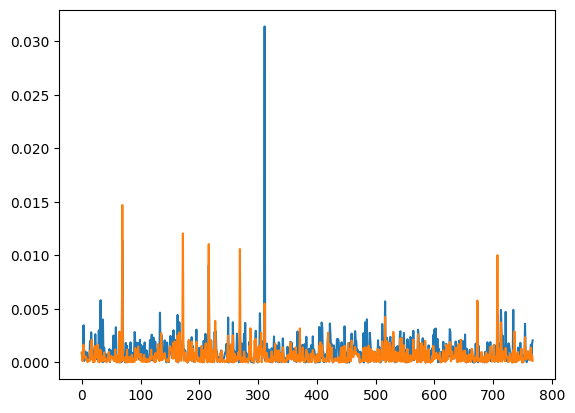

In [24]:
import matplotlib.pyplot as plt
plt.plot(np.abs(fl_out.flatten()))
plt.plot(np.abs(pt_out.detach().numpy().flatten()))

In [ ]:
print(parameter_overview.get_parameter_overview())
print(pt_layer, count_parameters(pt_layer))

In [ ]:
for k,v in pt_layer.named_parameters():
    print(k, v.shape)

vf = {'params':
          {'word_embeddings':
               {'embedding': None},
           'position_embeddings':
               {'embedding': None},
           'token_type_embeddings':
               {'embedding': None},
           'LayerNorm':
               {'bias': None,
                'scale': None},
        }
      }
for k,v in pt_layer.named_parameters():
    if k == 'word_embeddings.weight':
        vf['params']['word_embeddings']['embedding'] = v.detach().numpy()
    if k == 'position_embeddings.weight':
        vf['params']['position_embeddings']['embedding'] = v.detach().numpy()
    if k == 'token_type_embeddings.weight':
        vf['params']['token_type_embeddings']['embedding'] = v.detach().numpy()
    if k == 'LayerNorm.weight':
        vf['params']['LayerNorm']['scale'] = v.detach().numpy()
    if k == 'LayerNorm.bias':
        vf['params']['LayerNorm']['bias'] = v.detach().numpy()

print(vf)


In [8]:
# vf = f_layer.init(jax.random.PRNGKey(0), input_ids, token_ids,  position_ids, attention_mask)
f_out = f_layer.apply(vf, input_ids, token_ids, position_ids, attention_mask)
pt_out = pt_layer(input_ids=pt_input_ids, token_type_ids=pt_token_ids, position_ids=pt_position_ids)

In [9]:
print(vf['params']['word_embeddings']['embedding'].shape)
print(f_out.shape)
print(pt_out.shape)
print(np.abs(pt_out.detach().numpy() - f_out).sum())

(30522, 768)
(1, 5, 768)
torch.Size([1, 5, 768])
3.368198e-05


In [10]:
cam = np.random.rand(*f_out.shape)
f_cam = jnp.array( cam / cam.sum())
pt_cam = torch.tensor(cam / cam.sum())

f_cam1, f_cam2 = f_layer.apply(vf, f_cam, input_ids, token_ids, position_ids, attention_mask, method=f_layer.relprop)
kwargs = {'alpha': 1}
pt_cam1, pt_cam2 = pt_layer.relprop(pt_cam, **kwargs)


print(np.abs(np.array(f_cam1) - pt_cam1.detach().numpy()).sum())
print(np.abs(np.array(f_cam2) - pt_cam2.detach().numpy()).sum())
print(np.abs(np.array(f_cam1) - pt_cam2.detach().numpy()).sum())
print(np.sum(f_cam1) + np.sum(f_cam2))
print(np.sum(pt_cam1.detach().numpy()) + np.sum(pt_cam2.detach().numpy()))
print(f_cam2.shape)

relprop 2
2.7899752
2.787298
2.7194073
1.0000002
1.0
(1, 5, 768)


In [11]:
print(parameter_overview.get_parameter_overview(vf))
print(pt_layer, count_parameters(pt_layer))

+----------------------------------------+--------------+------------+-----------+-------+
| Name                                   | Shape        | Size       | Mean      | Std   |
+----------------------------------------+--------------+------------+-----------+-------+
| params/LayerNorm/bias                  | (768,)       | 768        | 0.0       | 0.0   |
| params/LayerNorm/scale                 | (768,)       | 768        | 1.0       | 0.0   |
| params/position_embeddings/embedding   | (512, 768)   | 393,216    | -0.00286  | 0.999 |
| params/token_type_embeddings/embedding | (2, 768)     | 1,536      | -0.00341  | 1.01  |
| params/word_embeddings/embedding       | (30522, 768) | 23,440,896 | -7.33e-05 | 1.0   |
+----------------------------------------+--------------+------------+-----------+-------+
Total: 23,837,184
BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)

In [12]:
pt_layer = BertEncoder(configuration).eval()
f_layer = FlaxBertEncoder(configuration)

In [13]:
for k,v in pt_layer.named_parameters():
    print(k, v.shape)

layer.0.attention.self.query.weight torch.Size([768, 768])
layer.0.attention.self.query.bias torch.Size([768])
layer.0.attention.self.key.weight torch.Size([768, 768])
layer.0.attention.self.key.bias torch.Size([768])
layer.0.attention.self.value.weight torch.Size([768, 768])
layer.0.attention.self.value.bias torch.Size([768])
layer.0.attention.output.dense.weight torch.Size([768, 768])
layer.0.attention.output.dense.bias torch.Size([768])
layer.0.attention.output.LayerNorm.weight torch.Size([768])
layer.0.attention.output.LayerNorm.bias torch.Size([768])
layer.0.intermediate.dense.weight torch.Size([3072, 768])
layer.0.intermediate.dense.bias torch.Size([3072])
layer.0.output.dense.weight torch.Size([768, 3072])
layer.0.output.dense.bias torch.Size([768])
layer.0.output.LayerNorm.weight torch.Size([768])
layer.0.output.LayerNorm.bias torch.Size([768])
layer.1.attention.self.query.weight torch.Size([768, 768])
layer.1.attention.self.query.bias torch.Size([768])
layer.1.attention.self.k

In [20]:
pt_m = BertModel(configuration).eval()
pt_in = pt_inputs
pt_out = pt_m(**pt_in)
pt_out[1].shape

torch.Size([1, 768])

In [8]:
pt_out.sum().backward()
one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
one_hot[0, index] = 1
one_hot_vector = one_hot
one_hot = torch.from_numpy(one_hot).requires_grad_(True)
one_hot = torch.sum(one_hot.cuda() * output)

self.model.zero_grad()
one_hot.backward(retain_graph=True)

/local/.conda/envs/dl_sys/lib/python3.10/site-packages/transformers/modeling_utils.py:735: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [9]:
cam = np.random.rand(*pt_out.shape)
pt_cam = torch.tensor(cam / cam.sum())
kwargs = {'alpha': 1}
pt_cams = pt_m.relprop(pt_cam, **kwargs)

tensor([[[0.0026, 0.0008, 0.0001,  ..., 0.0013, 0.0007, 0.0017],
         [-0.0000, 0.0000, 0.0000,  ..., 0.0000, -0.0000, -0.0000],
         [-0.0000, 0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [-0.0000, 0.0000, -0.0000,  ..., 0.0000, -0.0000, 0.0000],
         [-0.0000, 0.0000, 0.0000,  ..., 0.0000, -0.0000, 0.0000]]],
       grad_fn=<MulBackward0>)
tensor([[[ 1.4184e-03, -1.0720e-03,  6.7770e-04,  ...,  1.6326e-04,
           2.1099e-03,  2.7981e-03],
         [-1.3088e-04,  5.7206e-03,  9.1051e-04,  ..., -4.8278e-04,
          -3.3931e-03,  2.3779e-03],
         [ 1.9464e-04,  5.5653e-05, -1.4214e-05,  ...,  3.1613e-04,
           4.0099e-05,  1.2043e-05],
         [ 1.9841e-04,  6.3528e-04, -4.8302e-05,  ...,  6.4033e-06,
          -1.9505e-04, -3.1525e-04],
         [-9.5246e-06,  5.2908e-04,  1.9418e-04,  ..., -2.2420e-05,
           3.5546e-04,  9.9432e-04]]], grad_fn=<MulBackward0>)


In [13]:
def compute_rollout_attention(all_layer_matrices, start_layer=0):
    # adding residual consideration- code adapted from https://github.com/samiraabnar/attention_flow
    num_tokens = all_layer_matrices[0].shape[1]
    batch_size = all_layer_matrices[0].shape[0]
    eye = torch.eye(num_tokens).expand(batch_size, num_tokens, num_tokens).to(all_layer_matrices[0].device)
    all_layer_matrices = [all_layer_matrices[i] + eye for i in range(len(all_layer_matrices))]
    matrices_aug = [all_layer_matrices[i] / all_layer_matrices[i].sum(dim=-1, keepdim=True)
                          for i in range(len(all_layer_matrices))]
    joint_attention = matrices_aug[start_layer]
    for i in range(start_layer+1, len(matrices_aug)):
        joint_attention = matrices_aug[i].bmm(joint_attention)
    return joint_attention

In [15]:
cams = []
blocks = pt_m.encoder.layer
for blk in blocks:
    grad = blk.attention.self.get_attn_gradients()
    cam = blk.attention.self.get_attn_cam()
    cam = cam[0].reshape(-1, cam.shape[-1], cam.shape[-1])
    grad = grad[0].reshape(-1, grad.shape[-1], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    cams.append(cam.unsqueeze(0))
rollout = compute_rollout_attention(cams, start_layer=0)
rollout[:, 0, 0] = rollout[:, 0].min()
rollout[:, 0]

tensor([[0.0025, 0.0025, 0.0029, 0.0029, 0.0029]], grad_fn=<SelectBackward0>)